In [1]:
########## Part 1: Producing forecasts via traditional time series analysis (ARIMA)

In [2]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

# fix random seed for reproducibility
np.random.seed(123)

In [3]:
# import CPI data (monthly data from 1961 to 2017)
cpi = pd.read_csv('../data/consumer_price_index/cpi.csv')

# create month index
cpi['month'] = pd.to_datetime(cpi['month'], infer_datetime_format=True)
cpi = cpi.set_index(['month'])

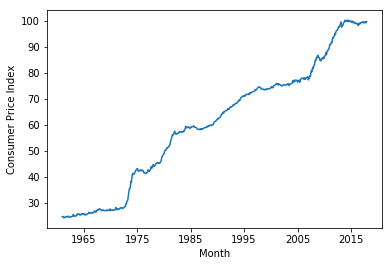

In [4]:
# plot graph
plt.xlabel('Month')
plt.ylabel('Consumer Price Index')
plt.plot(cpi['cpi']) # upward trend, hence not stationary

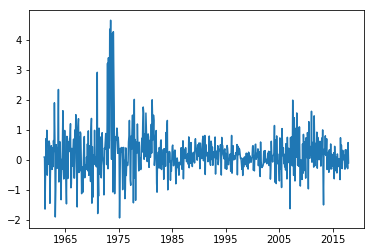

In [5]:
# remove trend: take first difference of log values
log_cpi = np.log(cpi)
dlog_cpi = log_cpi - log_cpi.shift(1)
dlog_cpi = dlog_cpi*100 # convert to percentage terms
plt.plot(dlog_cpi)
plt.show() # trend has been removed

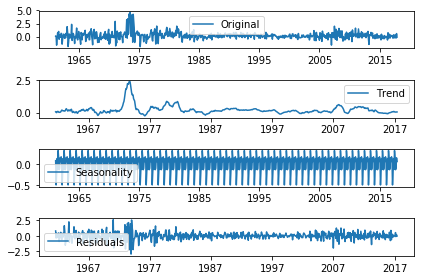

In [6]:
### remove seasonal component (if any)

# break down a time series into its trend, seasonal, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dlog_cpi.dropna())

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dlog_cpi, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality') # seems that there is indeed seasonality
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# remove seasonal component
dlog_cpi_sa = dlog_cpi - seasonal

In [7]:
# confirm stationarity via augmented dickey-fuller test (null hypothesis: series is non-stationary)
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(dlog_cpi_sa['cpi'].dropna(), autolag='AIC') # use akaike IC to determine no. of lags to include in ADF test

print('p-value from ADF test is:', adf_test[1]) # reject the null of non-stationarity

p-value from ADF test is: 1.9672070377882726e-06


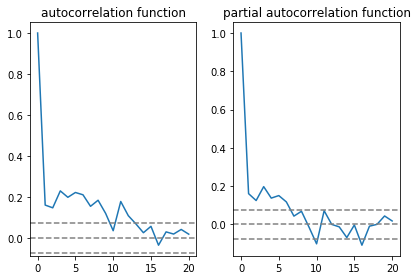

In [8]:
### determine number of autoregressive and moving average terms in AR and MA model respectively
from statsmodels.tsa.stattools import acf, pacf

dlog_cpi_sa.dropna(inplace=True)
lag_acf = acf(dlog_cpi_sa, nlags=20)
lag_pacf = pacf(dlog_cpi_sa, nlags=20, method='ols')

# plot ACF: to determine number of MA terms
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.title('autocorrelation function')
# number of MA terms = 9 (acf graph enters confidence interval for the first time when # lags = 10)

# plot PACF: to determine number of AR terms
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.title('partial autocorrelation function')
plt.tight_layout()
# number of AR terms = 6 (pacf graph enters confidence interval for the first time when # lags = 7)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


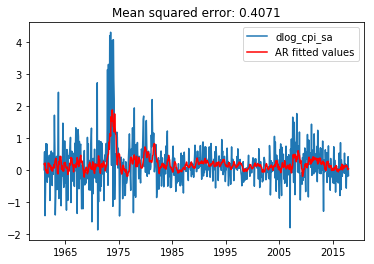

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


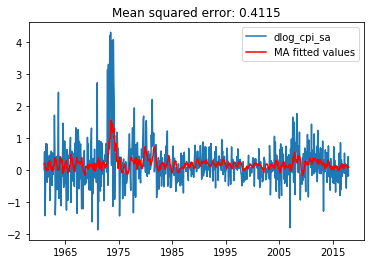

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


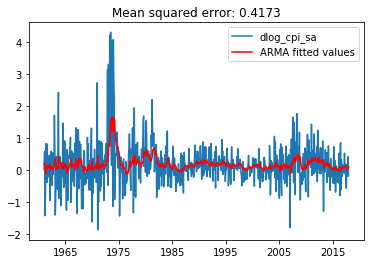

                              ARMA Model Results                              
Dep. Variable:                    cpi   No. Observations:                  683
Model:                     ARMA(6, 0)   Log Likelihood                -662.023
Method:                       css-mle   S.D. of innovations              0.638
Date:                Sat, 29 Sep 2018   AIC                           1340.045
Time:                        16:32:32   BIC                           1376.257
Sample:                    02-01-1961   HQIC                          1354.059
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1995      0.063      3.154      0.002       0.076       0.324
ar.L1.cpi      0.0501      0.038      1.320      0.187      -0.024       0.125
ar.L2.cpi      0.0404      0.038      1.075      0.2

In [9]:
### let's compare AR vs MA vs ARMA
from statsmodels.tsa.arima_model import ARIMA

# AR
model = ARIMA(dlog_cpi_sa, order=(6, 0, 0))  
results_ar = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_ar.fittedvalues, color='red', label='AR fitted values')
plt.title('Mean squared error: %.4f'% ((results_ar.fittedvalues-dlog_cpi_sa['cpi'])**2).mean())
plt.legend(loc='best')
plt.show()

# MA
model = ARIMA(dlog_cpi_sa, order=(0, 0, 9))  
results_ma = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_ma.fittedvalues, color='red', label='MA fitted values')
plt.title('Mean squared error: %.4f'% ((results_ma.fittedvalues-dlog_cpi_sa['cpi'])**2).mean())
plt.legend(loc='best')
plt.show()

# ARMA
model = ARIMA(dlog_cpi_sa, order=(1, 0, 1))  
results_arma = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_arma.fittedvalues, color='red', label='ARMA fitted values')
plt.title('Mean squared error: %.4f'% ((results_arma.fittedvalues-dlog_cpi_sa['cpi'])**2).mean())
plt.legend(loc='best')
plt.show()

# AR model has the lowest MSE out of the three models

# view summary of best model
print(results_ar.summary())

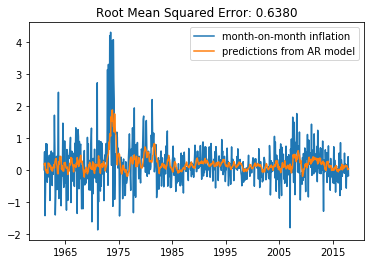

In [10]:
# generate in-sample predictions
predictions_ar = pd.Series(results_ar.fittedvalues, copy=True)

# compare predictions against original series
plt.plot(dlog_cpi_sa['cpi'], label='month-on-month inflation')
plt.plot(predictions_ar, label='predictions from AR model')
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(((predictions_ar-dlog_cpi_sa['cpi'])**2).mean()))
plt.legend(loc='best')
plt.show() # predictions seem to co-move well with actual values

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

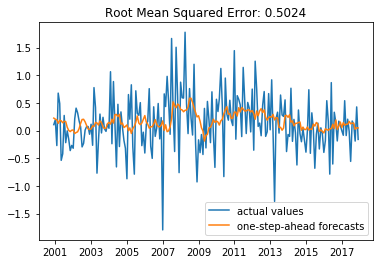

In [11]:
##### let's check the out-of-sample accuracy of the one-step-ahead forecasts

### split the data into train and test sets
train=dlog_cpi_sa[0:int(dlog_cpi_sa.shape[0]*0.7)]
test=dlog_cpi_sa[int(dlog_cpi_sa.shape[0]*0.7):dlog_cpi_sa.shape[0]]

### estimate the model via expanding window estimation, then generate out-of-sample one-step-ahead forecast. repeat for the length of the test set.
history=train['cpi']
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(6,0,0))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    obs = test['cpi'][t:t+1]
    history = history.append(obs)

predictions = pd.DataFrame({'prediction':predictions}).set_index(test.index)

### plot graph to show out-of-sample accuracy of 1-step ahead forecasts
plt.plot(test, label='actual values')
plt.plot(predictions, label='one-step-ahead forecasts')
plt.legend(loc='best')
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(((predictions['prediction']-test['cpi'])**2).mean()))
plt.show()

# out-of-sample predictions seem to co-move well with actual values

In [12]:
########## Part 2: Producing forecasts via a machine learning model (LSTM network)

In [13]:
# normalize the dataset via min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dlog_cpi_sa_scaled = scaler.fit_transform(dlog_cpi_sa)

### split the data into train and test sets
train_scaled = dlog_cpi_sa_scaled[0:int(dlog_cpi_sa_scaled.shape[0]*0.7)]
test_scaled = dlog_cpi_sa_scaled[int(dlog_cpi_sa_scaled.shape[0]*0.7):dlog_cpi_sa_scaled.shape[0]]

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+look_back
look_back = 1 # adjust as desired
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# create and fit the LSTM network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))  # hidden layer contains 4 LSTM blocks
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=0) # train the model

Using TensorFlow backend.


In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.7184 RMSE
Test Score: 0.5150 RMSE


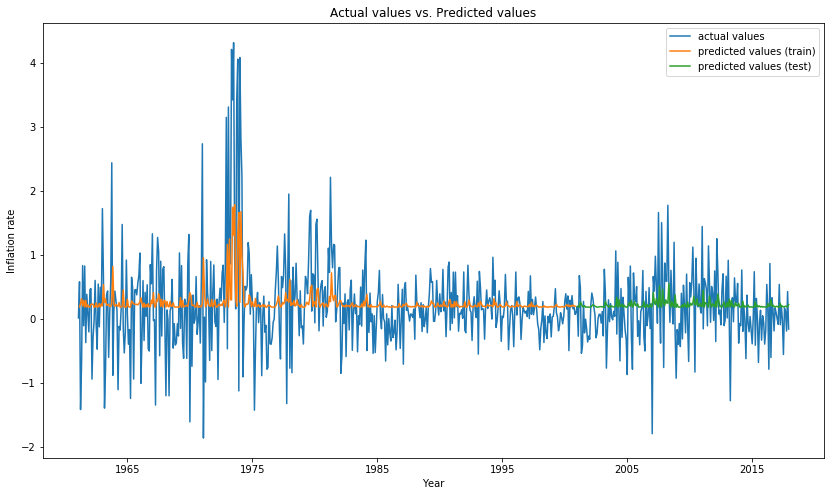

In [17]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dlog_cpi_sa_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dlog_cpi_sa_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dlog_cpi_sa_scaled), :] = testPredict

# plot actual values and predictions
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=14,8

plt.plot(dlog_cpi_sa.values, label='actual values')
plt.plot(trainPredictPlot, label='predicted values (train)')
plt.plot(testPredictPlot, label='predicted values (test)')
plt.legend(loc='best')
plt.title('Actual values vs. Predicted values')
plt.xlabel('Year')
plt.ylabel('Inflation rate')
plt.xticks(np.array([47,167,287,407,527,647]),['1965','1975','1985','1995','2005','2015'])
plt.show()

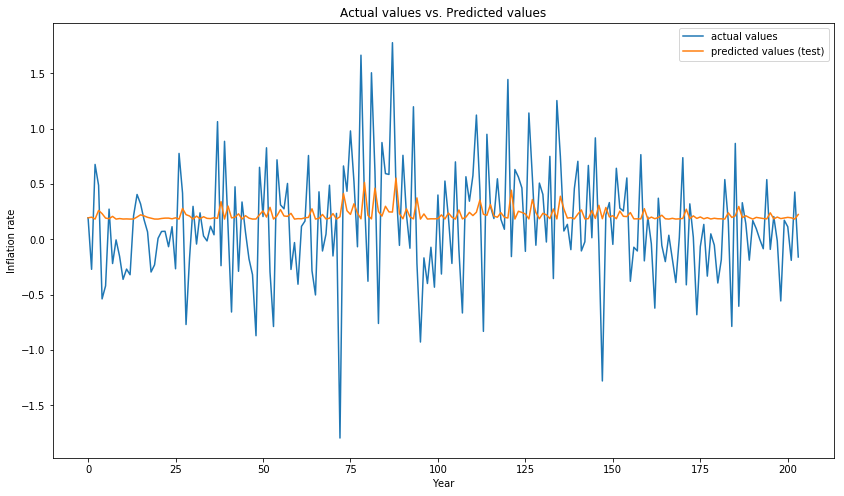

In [18]:
# plot: focus on the test obs
plt.plot(dlog_cpi_sa[len(trainPredict)+(look_back*2):].values, label='actual values')
plt.plot(testPredictPlot[len(trainPredict)+(look_back*2):], label='predicted values (test)')
plt.legend(loc='best')
plt.title('Actual values vs. Predicted values')
plt.xlabel('Year')
plt.ylabel('Inflation rate')
plt.show()

In [19]:
import gc
gc.collect()

8013